In [1]:
import os
import random
import time
import sys
import nltk
import re
import jieba
import torch
import numpy as np
import collections
import torch.utils.data as Data
import torchtext.vocab as vo
from tqdm import tqdm
from torch import nn
from matplotlib import pyplot as plt

In [2]:
def readData(tag='train', data_root="./data/"):
    """
    读取数据

    参数：
        tag: train, test
        data_root: 数据集根目录
    返回：
        data: list, 元素为[review, label]，review为字符串，label为0或1
    """
    data = []
    input_file = os.path.join(data_root, "{0}.csv".format(tag))
    with open(input_file, 'r', encoding="utf8") as f:
        head_line = f.readline()
        for line in tqdm(f):
            line = line.strip()
            label = int(line[0])
            review = line[2:]
            data.append([review, label])  # 评论文本字符串和01标签
    random.shuffle(data)
    return data


def tokenizer(text):
    return [tok for tok in jieba.cut(text)]


def getTokenized(data):
    """
    获得分词后的数据

    参数：
        data: list, 元素为[review, label]，review为字符串，label为0或1
    返回：
        data: list, 元素为[review, label]，review为分词后的list，label为0或1
    """
    return [tokenizer(review) for review, _ in data]


def getVocab(tokendata):
    """
    获得词表

    参数：
        data: list, 元素为[review, label]，review为分词后的list，label为0或1
    返回：
        vocab: list, 词表
    """
    counter = collections.Counter([tk for st in tokendata for tk in st])
    vocabDict = vo.vocab(counter, min_freq=1)
    vocabDict.insert_token('<unk>', 1)
    vocabDict.insert_token('<pad>', 0)
    return vocabDict


def pad(text, vocab, maxLen=64):
    return text[:maxLen] if len(text) > maxLen else text + [vocab['<pad>']] * (maxLen - len(text))


def preProcessData(tokendata, data, vocab, maxLen=64):
    """
    预处理数据

    参数：
        data: list, 元素为[review, label]，review为分词后的list，label为0或1
        vocab: list, 词表
        maxLen: int, 最大长度
    返回：
        data: list, 元素为[review, label]，review为分词后的list，label为0或1
    """
    
    padTokenData=[]
    for words in tokendata:
        indexWord = [vocab[words] if words in vocab else vocab['<unk>'] for words in words]
        padWord = pad(indexWord, vocab, maxLen)
        padTokenData.append(padWord)
    features = torch.tensor(padTokenData)
    labels = torch.tensor([label for _, label in data])
    return features, labels


def makeDataset(batchsize=64, maxlength=64, mincount=5):
    """
    生成数据集

    参数：
        batchsize: int, 批大小
        maxlength: int, 最大长度
        mincount: int, 最小词频
    返回：
        train_iter: 训练集迭代器
        test_iter: 测试集迭代器
        vocab: 词表
    """
    trainData = readData(tag='train')
    testData = readData(tag='test')
    trainTokenData = getTokenized(trainData)
    testTokenData = getTokenized(testData)
    vocab = getVocab(trainTokenData)
    trainFeatures, trainLabels = preProcessData(trainTokenData, trainData, vocab, maxlength)
    testFeatures, testLabels = preProcessData(testTokenData, testData, vocab, maxlength)
    train_dataset=Data.TensorDataset(trainFeatures, trainLabels)
    test_dataset=Data.TensorDataset(testFeatures, testLabels)
    train_loader = Data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    test_loader = Data.DataLoader(test_dataset, batch_size=batchsize, shuffle=True)
    return train_loader, test_loader, vocab





def saveVocab(vocab, path='./output/model.vocab'):
    """
    保存词表

    参数：
        vocab: 词表
        path: 保存路径
    """
    with open(path, 'w', encoding="utf8") as output:
        print("\n".join(vocab.get_itos()), file=output)


def loadVocab(path='./output/model.vocab'):
    """
    读取词表

    参数：
        path: 读取路径
    返回：
        vocab: 词表
    """
    vocab = {}
    with open(path, 'r', encoding="utf8") as f:
        for i, line in enumerate(f):
            vocab[line.strip()] = i
    vocabDict=vo.vocab(vocab, min_freq=0)
    return vocabDict


def loadPreTrainEmbedding(words,preTrainVocabPath='./data/glove/',embedSize=100,type='glove'):
    """
    加载预训练词向量

    参数：
        words: 词表
        preTrainVocabPath: 预训练词向量路径
        embedSize: 词向量维度
    返回：
        embed: 词向量
    """
    embed = torch.normal(mean=0, std=1, size=(len(words), embedSize))
    if type=='glove':
        preTrainVocab = vocab.GloVe(name='6B', dim=embedSize, cache=preTrainVocabPath)
    elif type=='word2vec':
        preTrainVocab = vocab.Word2VecTextFile(preTrainVocabPath)
    else:
        return embed
    preTrainVocabSize = preTrainVocab.vectors.shape[0]
    outofvocab = 0
    for i, word in enumerate(words):
        try:
            index = preTrainVocab.stoi[word]
            if preTrainVocabSize == embedSize:
                embed[i,:] = preTrainVocab.vectors[index]
            elif preTrainVocabSize > embedSize:
                embed[i,:] = preTrainVocab.vectors[index][:embedSize]
            else:
                embed[i,:] = preTrainVocab.vectors[index] + [0] * (embedSize - preTrainVocabSize)
        except:
            outofvocab += 1
    if outofvocab > 0:
        print('out of vocab: %d' % outofvocab)
    return embed

In [3]:
train_loader, test_loader, vocab_dict=makeDataset()

114026it [00:00, 340723.57it/s]
5962it [00:00, 424579.19it/s]
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\76608\AppData\Local\Temp\jieba.cache
Loading model cost 0.789 seconds.
Prefix dict has been built successfully.


In [4]:
saveVocab(vocab_dict)

In [5]:
# 定义模型
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, bidirectional, num_classes, drop_prob=0.5):
        """
        初始化模型

        参数：
            vocab_size: int, 词表大小
            embed_size: int, 词向量维度
            num_hiddens: int, 隐藏层维度
            num_layers: int, 隐藏层层数
            bidirectional: bool, 是否双向
            num_classes: int, 类别数
            drop_prob: float, dropout概率

        """
        super(BiRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(input_size=embed_size,
                               hidden_size=num_hiddens,
                               num_layers=num_layers,
                               bidirectional=bidirectional,
                               dropout=drop_prob)
        self.decoder = nn.Linear(4 * num_hiddens, num_classes)
    
    def forward(self, inputs):
        """
        前向传播

        参数：
            inputs: Tensor, 输入
        返回：
            outputs: Tensor, 输出
        """
        inputs=inputs.permute(1,0)
        # torch.Size([64, 64])
        embeddings = self.embedding(inputs)
        # torch.Size([64, 64, 64])
        outputs, _ = self.encoder(embeddings)
        # torch.Size([64, 64, 128])
        encoding = torch.cat((outputs[0], outputs[-1]), -1)
        # torch.Size([64, 256])
        outs = self.decoder(encoding)
        # torch.Size([64, 2])
        return outs

In [6]:
def testModel():
    """
    测试模型
    """
    model = BiRNN(vocab_size=5000, embed_size=100, num_hiddens=100, num_layers=2, bidirectional=True, num_classes=2)
    print(model)

In [7]:
testModel()

BiRNN(
  (embedding): Embedding(5000, 100)
  (encoder): LSTM(100, 100, num_layers=2, dropout=0.5, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# 准确率
def accuracy(data_iter, model, device):
    """
    计算准确率

    参数：
        data_iter: DataLoader, 数据迭代器
        model: 模型
        device: 设备
    返回：
        acc: float, 准确率
    """
    model.eval()
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            acc_sum += (model(X).argmax(dim=1) == y).float().sum().cpu().item()
            n += y.shape[0]
    return acc_sum / n

In [10]:
def train(train_loader, test_loader, model, loss, optimizer, device, epochs):
    model = model.to(device)
    print("training on ", device)
    batch_count = 0
    trainLoss = []
    trainAcc = []
    testAcc = []
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        model.train()
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = accuracy(test_loader, model, device)
        trainLoss.append(train_l_sum / batch_count)
        trainAcc.append(train_acc_sum / n)
        testAcc.append(test_acc)
        # print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
            #   % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    plt.plot(np.arange(epochs), trainLoss, label='train loss')
    plt.plot(np.arange(epochs), trainAcc, label='train acc')
    plt.plot(np.arange(epochs), testAcc, label='test acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


In [11]:
embed_size = 64
num_hiddens = 64
num_layers = 2
bidirectional = True
num_classes = 2
drop_prob = 0.9
lr = 0.01
epochs = 2
net = BiRNN(vocab_size=len(vocab_dict), embed_size=embed_size, num_hiddens=num_hiddens, num_layers=num_layers, bidirectional=bidirectional, num_classes=num_classes, drop_prob=drop_prob)
print(net)

BiRNN(
  (embedding): Embedding(196816, 64)
  (encoder): LSTM(64, 64, num_layers=2, dropout=0.9, bidirectional=True)
  (decoder): Linear(in_features=256, out_features=2, bias=True)
)


In [12]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

training on  cuda


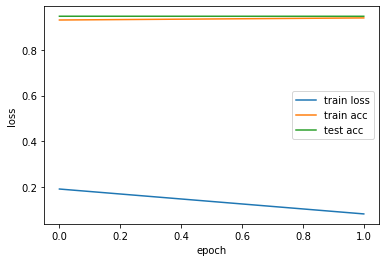

In [13]:
train(train_loader, test_loader, net, loss, optimizer, device, epochs)

In [14]:
outputModelPath='output/model.pt'
torch.save(net, outputModelPath)

In [16]:
def cleanText(text):
    """
    清洗文本

    参数：
        text: str, 文本
    返回：
        text: str, 清洗后的文本
    """
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text


def makeIter(texts, vocab_path='output/model.vocab', batch_size=64, max_length=64):
    """
    生成迭代器

    参数：
        texts: list, 文本列表
        vocab_path: str, 词表路径
        batch_size: int, 批大小
        max_length: int, 最大长度
    返回：
        data_iter: DataLoader, 数据迭代器
    """
    data=[]
    for text in texts:
        text=cleanText(text)
        data.append([text,-1])
    vocab=loadVocab(vocab_path)
    tokenizedData = getTokenized(data)
    features, labels = preProcessData(tokenizedData, data, vocab, max_length)
    dataset = Data.TensorDataset(features, labels)
    data_iter = Data.DataLoader(dataset, batch_size, shuffle=False)
    return data_iter


def makeIterOfFile(filePath='data/infer.txt', vocab_path='output/model.vocab', batch_size=64, max_length=64):
    """
    生成迭代器

    参数：
        filePath: str, 文件路径
        vocab_path: str, 词表路径
        batch_size: int, 批大小
        max_length: int, 最大长度
    返回：
        data_iter: DataLoader, 数据迭代器
    """
    data = []
    with open(filePath, 'r', encoding='utf-8') as f:
        for line in f:
            line = cleanText(line)
            line = line.strip()
            if line:
                data.append([line, -1])
    vocab = loadVocab(vocab_path)
    tokenizedData = getTokenized(data)
    features, labels = preProcessData(tokenizedData, data, vocab, max_length)
    dataset = Data.TensorDataset(features, labels)
    data_iter = Data.DataLoader(dataset, batch_size, shuffle=False)
    return data_iter, vocab

def inference(text_iter, device, outputModelPath='output/model.pt'):
    """
    预测

    参数：
        text: str, 文本
        outputModelPath: str, 模型路径
    返回：
        label: int, 类别
    """
    model = torch.load(outputModelPath)
    model.eval()
    model = model.to(device)
    result=[]
    with torch.no_grad():
        for X, y in text_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            temp = y_hat.argmax(dim=1).cpu().numpy()
            result.extend(temp)
    return result

In [ ]:
text_iter, vocab = makeIterOfFile()
print("#vocab: ", len(vocab))
print('#batches:', len(text_iter))
result = inference(text_iter, device)
print(result)

In [18]:
testtext = ['I love54@@@@56465   $#%#   $@$@$@ sd fdf you','I hate you','You are so stupid','I am so happy','I am so sad']

In [19]:
dataIter=makeIter(testtext)
result=inference(dataIter,device)
print(result)